STA/LTARatio method for Lunar seismic detection.

In [ ]:
!pip install obspy
!pip install pykalman
!pip install scikit-optimize


# Read in and plot the Apollo 12 Grade A catalog

In [ ]:
# !apt-get install git
# !git config --global user.email "harry9harsha@gmail.com"
# !git config --global user.name "harshapbs"


In [ ]:
# !git clone git@github.com:mrcne/space-resonate/tree/main/my_model1

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import ParameterGrid

from pykalman import KalmanFilter
import skopt

from skopt import gp_minimize



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's take a look at the training data for the lunar dataset. In addition to the data itself, we include a catalog that will tell you which events happen when in the data. The catalog includes the name of the file, the absolute time, the relative time in seconds (relative to the start of the file), the event ID (evid), and the type of moonquake. The types of moonquakes include impacts, deep moonquakes, and shallow moonquakes. You do not have to worry about predicting the type of moonquakes, that's just fun information for you to know!

**Note**: For your prediction, feel free to include either the absolute time or relative time, just make sure to mark it using the same header in the CSV file so we can easily score it!

In [ ]:
filename= 'xa.s12.00.mhz.1970-04-03HR00_evid00021'

## Read the CSV file corresponding to that detection

We will now find the csv data file corresponding to that time and plot it!

In [ ]:
data_directory = '/content/drive/My Drive/NASA 2024 Space Apps Challenge Seismic/ColabSpaceApps2024/data/lunar/test/data/S12_GradeB/'
csv_file = filename + '.csv'
full_path = os.path.join(data_directory, csv_file)
data_cat = pd.read_csv(full_path)
# data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-04-03T00:00:00.350000,0.000000,-8.436221e-16
1,1970-04-03T00:00:00.500943,0.150943,-1.038930e-15
2,1970-04-03T00:00:00.651887,0.301887,-1.139941e-15
3,1970-04-03T00:00:00.802830,0.452830,-1.122193e-15
4,1970-04-03T00:00:00.953774,0.603774,-1.007203e-15
...,...,...,...
572418,1970-04-04T00:00:03.066981,86402.716981,-3.916167e-15
572419,1970-04-04T00:00:03.217925,86402.867925,-3.886775e-15
572420,1970-04-04T00:00:03.368868,86403.018868,-3.375503e-15
572421,1970-04-04T00:00:03.519811,86403.169811,-2.802955e-15


Text(0.5, 1.0, 'xa.s12.00.mhz.1970-04-03HR00_evid00021')

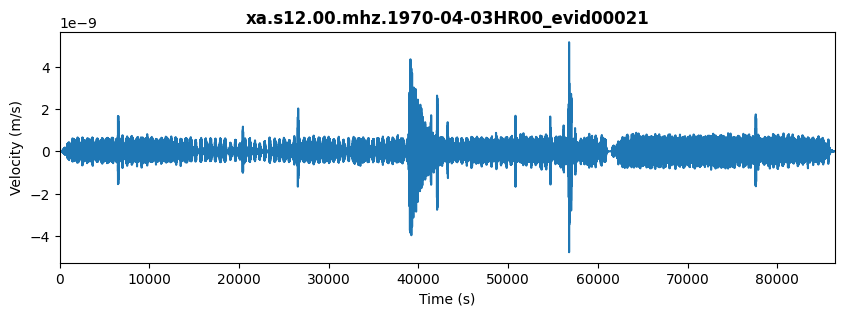

In [ ]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(filename, fontweight='bold')

# Plot where the arrival time is
# arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
# ax.legend(handles=[arrival_line])

What if you wanted to plot in absolute time instead? The operations are very similar, just with a little extra datetime. It takes a bit longer, so we recommend working in relative time to start with!

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-04-03HR00_evid00021')

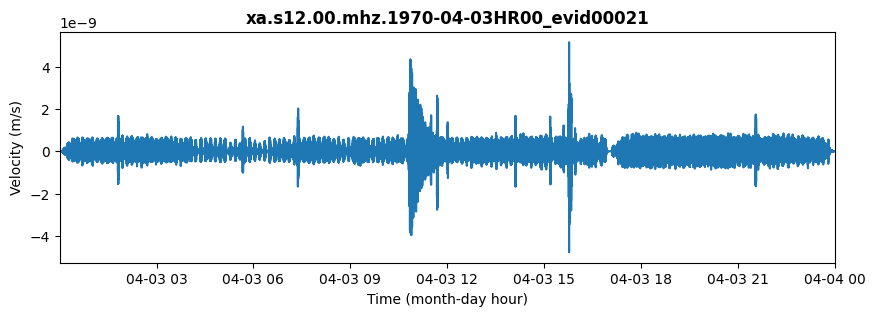

In [ ]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(filename, fontweight='bold')

# Plot where the arrival time is
# arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
# ax.legend(handles=[arrival_line])

### Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file.

In [ ]:
data_directory = '/content/drive/My Drive/NASA 2024 Space Apps Challenge Seismic/ColabSpaceApps2024/data/lunar/test/data/S12_GradeB/'
mseed_file = filename +'.mseed'
full_path = os.path.join(data_directory, mseed_file)
st = read(full_path)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-04-03T00:00:00.350000Z - 1970-04-04T00:00:03.670755Z | 6.6 Hz, 572423 samples

In [ ]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-04-03T00:00:00.350000Z
         endtime: 1970-04-04T00:00:03.670755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [ ]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# # Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
# arrival = (arrival_time - starttime).total_seconds()
# arrival

### Plot the trace and mark the arrival!

Use a similar method to plot the miniseed data and seismic arrival.

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-04-03HR00_evid00021')

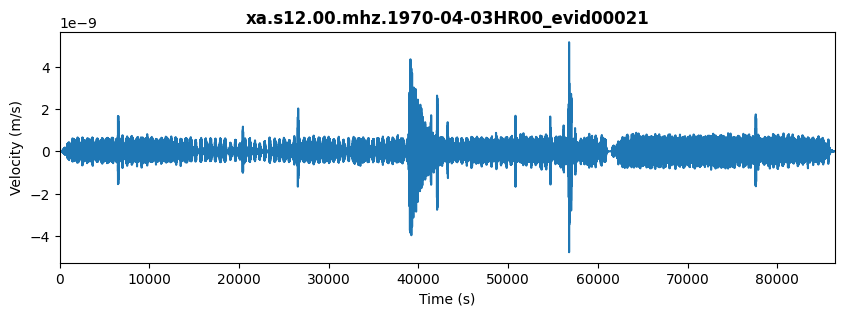

In [ ]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
# ax.axvline(x = arrival, color='red',label='Rel. Arrival')
# ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(filename, fontweight='bold')

There are multiple ways that we can do the absolute time using datetime, here is a simple way using the `.timedelta` method

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-04-03HR00_evid00021')

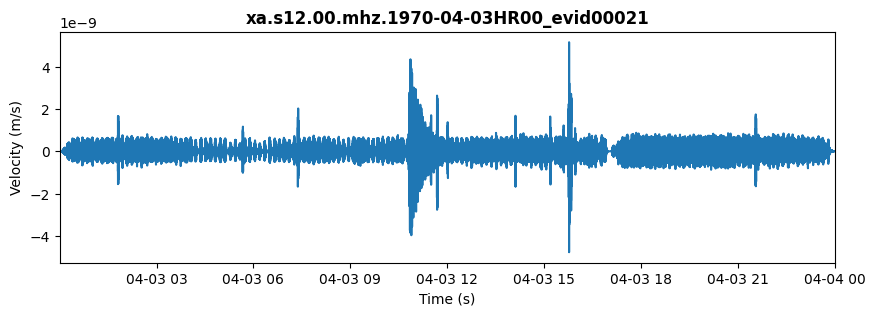

In [ ]:
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
# arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
# ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(filename, fontweight='bold')


It's completely up to you whether to work with the CSV file or the miniseed files. We recommend working with the miniseed file as it's a bit faster to run.

## Let's filter the trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz.

In [ ]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 3

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [ ]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

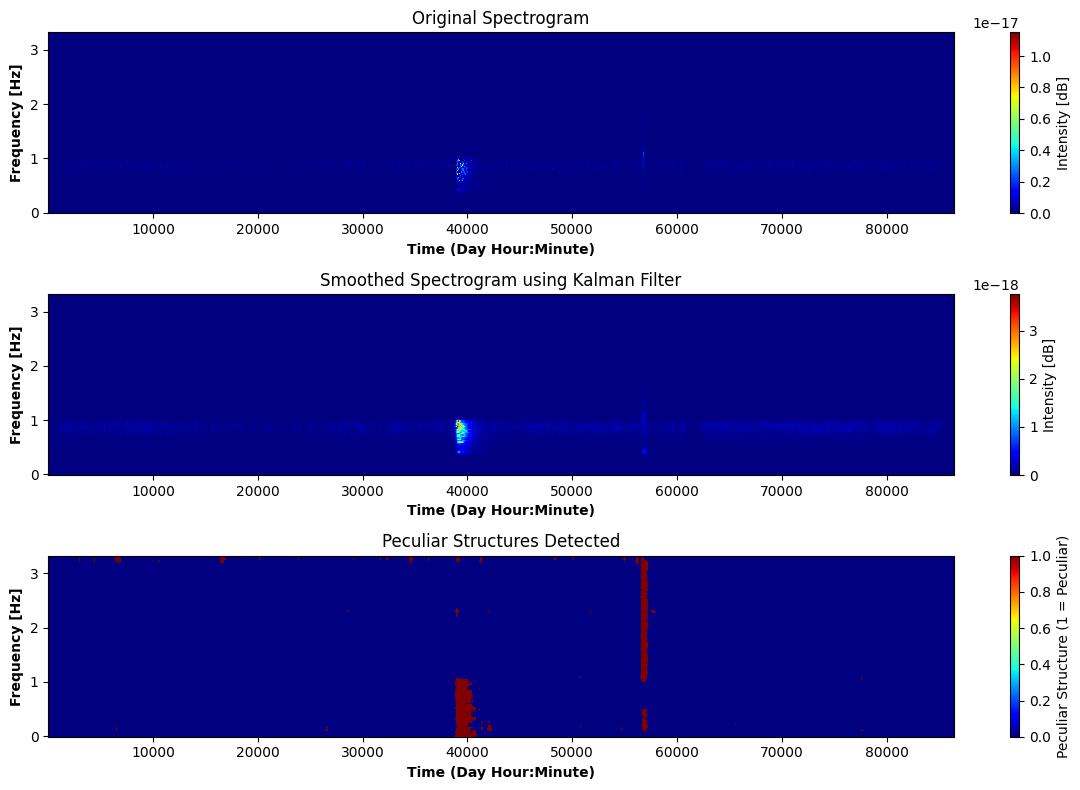

In [ ]:
# Set up Kalman Filter parameters
n_frequencies = sxx.shape[0]  # Number of frequency bins
smoothed_states = np.zeros_like(sxx)  # To store smoothed states
peculiar_structures = np.zeros_like(sxx)  # To store peculiar structures (0 = normal, 1 = peculiar)

# Loop over each frequency bin to apply Kalman Filter
for i in range(n_frequencies):
    # Extract the time series for the current frequency
    measurements = sxx[i, :]

    # Define the Kalman Filter
    kf = KalmanFilter(
        transition_matrices=np.array([[1]]),  # Identity transition matrix
        observation_matrices=np.array([[1]]),  # Observation matrix
        initial_state_mean=measurements[0],     # Start at the first value of the series
        initial_state_covariance=1,              # Initial guess for state covariance
        observation_covariance=1,                 # Observation noise
        transition_covariance=0.1                 # Model noise
    )

    # Estimate the smoothed state (filtered signal)
    smoothed_state, _ = kf.smooth(measurements)

    # Store the smoothed state (flattening to 1D)
    smoothed_states[i, :] = smoothed_state.flatten()

    # Define threshold for detecting peculiar structures (example: mean + 2 * std)
    threshold = np.mean(smoothed_state.flatten()) + 2 * np.std(smoothed_state.flatten())

    # Detect peculiar structures (where smoothed state > threshold)
    peculiar_indices = np.where(smoothed_state.flatten() > threshold)[0]  # Get the indices
    peculiar_structures[i, peculiar_indices] = 1  # Mark peculiar structures at those indices


# Plot the original and smoothed spectrogram
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title('Original Spectrogram')
plt.pcolormesh(t, f, (sxx), cmap='jet')
# ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
plt.xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# plt.axvline(x=arrival, c='red')
plt.ylabel('Frequency [Hz]', fontweight='bold')
plt.colorbar(label='Intensity [dB]')

plt.subplot(3, 1, 2)
plt.title('Smoothed Spectrogram using Kalman Filter')
plt.pcolormesh(t, f, (smoothed_states), cmap='jet')
plt.xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# plt.axvline(x=arrival, c='red')
plt.ylabel('Frequency [Hz]', fontweight='bold')
plt.colorbar(label='Intensity [dB]')

plt.subplot(3, 1, 3)
plt.title('Peculiar Structures Detected')
plt.pcolormesh(t, f, peculiar_structures, cmap='jet')
plt.xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# plt.axvline(x=arrival, c='red')
plt.ylabel('Frequency [Hz]', fontweight='bold')
plt.colorbar(label='Peculiar Structure (1 = Peculiar)')

plt.tight_layout()
plt.show()

First peculiar structure detected at index 1149 (time: 38868.52830188679)
First peculiar structure detected at index 1150 (time: 38902.339622641506)
First peculiar structure detected at index 1150 (time: 38902.339622641506)
First peculiar structure detected at index 1149 (time: 38868.52830188679)
First peculiar structure detected at index 191 (time: 6477.2830188679245)
First peculiar structure detected at index 191 (time: 6477.2830188679245)
First peculiar structure detected at index 191 (time: 6477.2830188679245)
First peculiar structure detected at index 1154 (time: 39037.58490566038)
First peculiar structure detected at index 1154 (time: 39037.58490566038)
First peculiar structure detected at index 1152 (time: 38969.96226415094)
First peculiar structure detected at index 1152 (time: 38969.96226415094)
First peculiar structure detected at index 1150 (time: 38902.339622641506)
First peculiar structure detected at index 1149 (time: 38868.52830188679)
First peculiar structure detected a

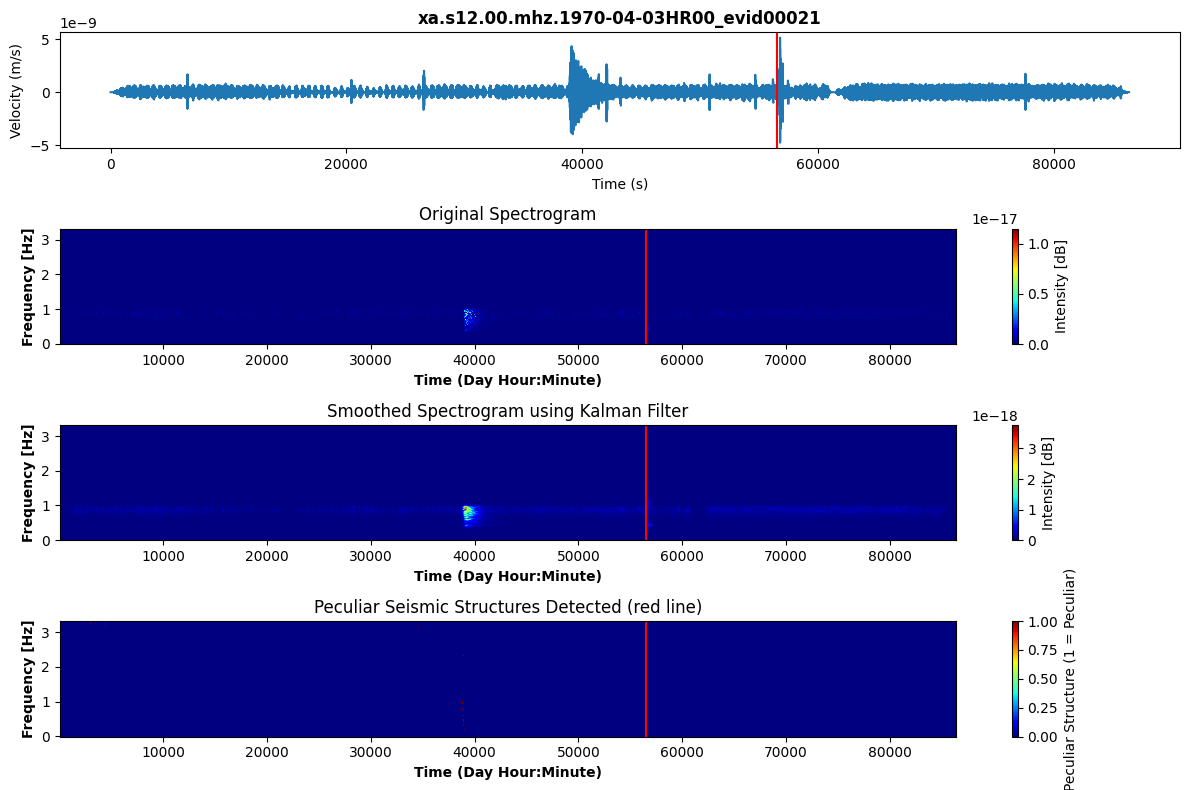

In [ ]:
# Set up Kalman Filter parameters
test_catalogue = []
n_frequencies = sxx.shape[0]  # Number of frequency bins
smoothed_states = np.zeros_like(sxx)  # To store smoothed states
peculiar_structures = np.zeros_like(sxx)  # To store peculiar structures (0 = normal, 1 = peculiar)

# Loop over each frequency bin to apply Kalman Filter
for i in range(n_frequencies):
    # Extract the time series for the current frequency
    measurements = sxx[i, :]

    # Define the Kalman Filter
    kf = KalmanFilter(
        transition_matrices=np.array([[1]]),  # Identity transition matrix
        observation_matrices=np.array([[1]]),  # Observation matrix
        initial_state_mean=measurements[0],     # Start at the first value of the series
        initial_state_covariance=1,              # Initial guess for state covariance
        observation_covariance=1,                 # Observation noise
        transition_covariance=0.1                 # Model noise
    )

    # Estimate the smoothed state (filtered signal)
    smoothed_state, _ = kf.smooth(measurements)

    # Store the smoothed state (flattening to 1D)
    smoothed_states[i, :] = smoothed_state.flatten()

    # Define threshold for detecting peculiar structures (example: mean + 2 * std)
    threshold = np.mean(smoothed_state.flatten()) + 2 * np.std(smoothed_state.flatten())
    # threshold = np.mean(smoothed_state.flatten()) / np.std(smoothed_state.flatten())
    # Detect peculiar structures (where smoothed state > threshold)
    peculiar_indices = np.where(smoothed_state.flatten() > threshold)[0]  # Get the indices

    # Find the first occurrence of a peculiar structure, if any
    if len(peculiar_indices) > 0:
        first_peculiar_index = peculiar_indices[0]  # Get the first occurrence
        test_catalogue = test_catalogue + [(f"First peculiar structure detected at index {first_peculiar_index} (time: {t[first_peculiar_index]})")]
        print(f"First peculiar structure detected at index {first_peculiar_index} (time: {t[first_peculiar_index]})")
        # time_peculiar_index[i, first_peculiar_index] = t[first_peculiar_index]
        peculiar_structures[i, first_peculiar_index] = 1  # Mark the first peculiar structure

most_common_num = max(set(test_catalogue), key = test_catalogue.count)
print(filename + f"Seismic Event Detected: {most_common_num[45:72]}")


# Plot the original and smoothed spectrogram
plt.figure(figsize=(12, 8))

plt.subplot(4,1,1)
# plt.plot(csv_times,csv_data)
plt.plot(tr_times,tr_data)
# Mark detection
plt.axvline(x=(float(most_common_num[53:71].split(':')[-1].strip())), c='red')
# plt.legend(handles=[arrival_line])
# Make the plot pretty
# plt.xlim([min(tr_times_dt),max(tr_times_dt)])
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.title(filename, fontweight='bold')

plt.subplot(4, 1, 2)
plt.title('Original Spectrogram')
plt.pcolormesh(t, f, (sxx),  cmap='jet')
plt.xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# plt.axvline(x=arrival, c='red')
plt.axvline(x=(float(most_common_num[53:71].split(':')[-1].strip())), c='red')
plt.ylabel('Frequency [Hz]', fontweight='bold')
plt.colorbar(label='Intensity [dB]')

# (float(most_common_num[53:71]))

plt.subplot(4, 1, 3)
plt.title('Smoothed Spectrogram using Kalman Filter')
plt.pcolormesh(t, f, (smoothed_states),  cmap='jet')
plt.xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
plt.axvline(x=(float(most_common_num[53:71].split(':')[-1].strip())), c='red')
# plt.axvline(x=arrival, c='red')
plt.ylabel('Frequency [Hz]', fontweight='bold')
plt.colorbar(label='Intensity [dB]')

plt.subplot(4, 1, 4)
plt.title('Peculiar Seismic Structures Detected (red line)')
# plt.plot(t,np.transpose(peculiar_structures))
# plt.plot(t,)
plt.pcolormesh(t, f, peculiar_structures, cmap='jet')
plt.axvline(x=(float(most_common_num[53:71].split(':')[-1].strip())), c='red')
plt.xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# plt.axvline(x=arrival, c='red')
plt.ylabel('Frequency [Hz]', fontweight='bold')
plt.colorbar(label='Peculiar Structure (1 = Peculiar)')
# int(most_common_num[55:71])
plt.tight_layout()
plt.show()